# Causal Impact of Current Events on Wikipedia Page Views
In this notebook measurements are made of the causal impact of current events on Wikipedia page view time series. 

Causal impact is modeled using Google's [Causal Impact](https://google.github.io/CausalImpact/) R package which implements the algorithms described in the publication [Inferring Causal Impact Using Baysean Structural Time-Series Models](http://research.google.com/pubs/pub41854.html).  

The model is trained using time series of both the article impacted by the current event and control articles which are not affected by the event.  The constructed model predicts the counterfactual time series.  That is, the time series for the impacted article that would have resulted had the current event not taken place.  By considering the difference between the actual time series and the counterfactual one, the causal impact can be determined.

Time series of Wikipedia page views is obtained using the [pageviews](https://github.com/Ironholds/pageviews) R package. 

This example measures the impact of the [Orlando Night Club Shooting](https://en.wikipedia.org/wiki/2016_Orlando_nightclub_shooting) on views of the Wikipedia [Gun Control](https://en.wikipedia.org/wiki/Gun_control) article.  Control articles are [Violence](https://en.wikipedia.org/wiki/Violence), [Peace](https://en.wikipedia.org/wiki/Peace) and [Safety](https://en.wikipedia.org/wiki/Safety).

## Load Libraries
Load the `CausalImpact` and `pageviews` packages.

In [7]:
library(CausalImpact)
library("pageviews")

## Retrieve pageview counts

In [2]:
y_pageviews <- article_pageviews(article = "Gun_control", start = "2016032200", end = "2016062000")
y_pageviews[1,]
x1_pageviews <- article_pageviews(article = "Violence", start = "2016032200", end = "2016062000")
x1_pageviews[1,]
x2_pageviews <- article_pageviews(article = "Peace", start = "2016032200", end = "2016062000")
x2_pageviews[1,]
x3_pageviews <- article_pageviews(article = "Safety", start = "2016032200", end = "2016062000")
x3_pageviews[1,]

,project,article,timestamp,access,agent,views
1,en.wikipedia,Gun_control,2016032200,all-access,all-agents,1075


,project,article,timestamp,access,agent,views
1,en.wikipedia,Violence,2016032200,all-access,all-agents,1341


,project,article,timestamp,access,agent,views
1,en.wikipedia,Peace,2016032200,all-access,all-agents,876


,project,article,timestamp,access,agent,views
1,en.wikipedia,Safety,2016032200,all-access,all-agents,919


## Create Data Set
From the dataframes above, create a time series data set consisting of the response variable `y` and predictors `x(i)`.

              y   x1   x2  x3
2016-03-22 1075 1341  876 919
2016-03-23  948 1265  914 801
2016-03-24  740 1147 1032 708
2016-03-25  527  821  725 571
2016-03-26  389  789  737 526
2016-03-27  489  735  750 657

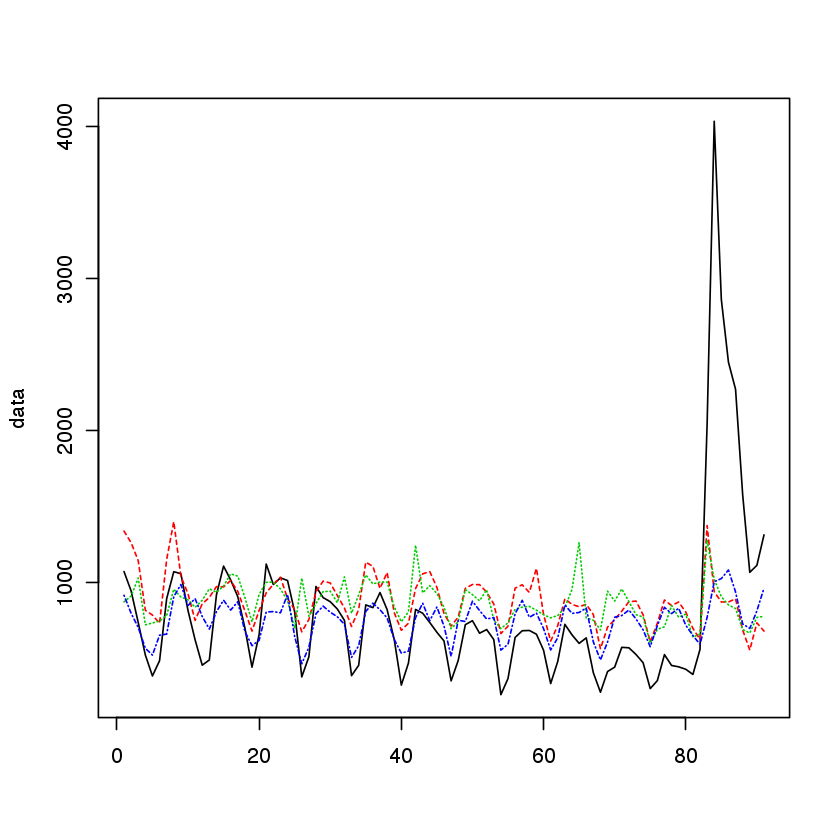

In [3]:
time.points <- seq.Date(as.Date("2016-03-22"), by = 1, length.out = nrow(y_pageviews))
data <- zoo(cbind(y_pageviews["views"], x1_pageviews["views"], x2_pageviews["views"], x3_pageviews["views"]), time.points)
colnames(data) <- c("y", "x1", "x2", "x3")
head(data)

matplot(data, type = "l")


## Construct Time Series Model
A time series model is contstructed with the intervention period set to the day of the Orlando shooting and the following two days.  A weekly seasonality component is used, since Wikipedia veiwing is cyclical, with page views decreasing on weekends.

In [4]:
pre.period <- as.Date(c("2016-03-22", "2016-06-11"))
post.period <- as.Date(c("2016-06-15", "2016-06-20"))

impact <- CausalImpact(data, pre.period, post.period,model.args = list(nseasons = 7, season.duration = 1))

## Plot Results

The results of the model are visualized in the following three panels.  The first one shows the actual page views for the *Gun Control* article and the counterfactual predition.  The second panel displays the difference between the actual and counterfactual.  The last panel is the cumulative increase in views of the *Gun Control* article as a result of the *Orlando Nightclub Shooting*.

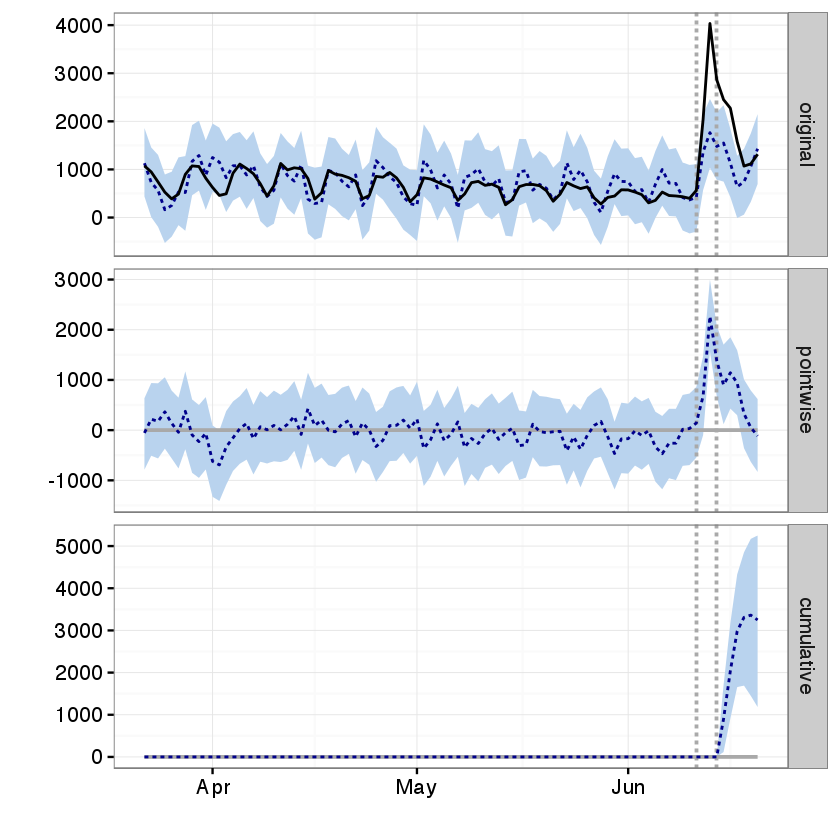

In [5]:
options(warn=-1) # suppresses warnings form geom_path about missing row values
plot(impact)
options(warn=0)  # restore warnings

## Summary Reports

In [6]:
summary(impact)

summary(impact,"report")

impact$summary

Posterior inference {CausalImpact}

                         Average       Cumulative  
Actual                   1634          9806        
Prediction (s.d.)        1093 (177)    6557 (1064) 
95% CI                   [759, 1437]   [4555, 8624]
                                                   
Absolute effect (s.d.)   541 (177)     3249 (1064) 
95% CI                   [197, 875]    [1182, 5251]
                                                   
Relative effect (s.d.)   50% (16%)     50% (16%)   
95% CI                   [18%, 80%]    [18%, 80%]  

Posterior tail-area probability p:   0.002
Posterior prob. of a causal effect:  99.8%

For more details, type: summary(impact, "report")

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 1.63K. By contrast, in the absence of an intervention, we would have expected an average response of 1.09K. The 95% interval of this counterfactual prediction is [0.76K, 1.44K]. Sub

,Actual,Pred,Pred.lower,Pred.upper,Pred.sd,AbsEffect,AbsEffect.lower,AbsEffect.upper,AbsEffect.sd,RelEffect,RelEffect.lower,RelEffect.upper,RelEffect.sd,alpha,p
Average,1634.3333333,1092.9126245,759.2428103,1437.3798184,177.3965566,541.4207088,196.9535149,875.0905230,177.3965566,0.4953925,0.1802098,0.8006958,0.1623154,0.0500000,0.0020000
Cumulative,9806.0000000,6557.4757470,4555.4568620,8624.2789107,1064.3793398,3248.5242530,1181.7210893,5250.5431380,1064.3793398,0.4953925,0.1802098,0.8006958,0.1623154,0.0500000,0.0020000
